In [1]:
import numpy as np
from scipy.special import expit
from scipy.optimize import minimize

import matplotlib as mpl
from matplotlib import pyplot as plt

# Regularized Logistic Regression

Recall our logistic cost function:
$$
J(\theta) = -\frac{1}{m}\left[\sum_{i=1}^m y^{(i)}\log h_\theta(x^{(i)}) + (1 - y^{(i)})\log (1 - h_\theta(x^{(i)})\right]
$$

When using high-order polynomials in our cost function, this can tend to lead to over-fitting, where $theta_i$'s get large to create tightly turning decision boundaries.  We can avoid this through *regularization*, i.e., by adding a penalty term for large $\theta_i$'s.

$$
J(\theta) = -\frac{1}{m}\left[\sum_{i=1}^m y^{(i)}\log h_\theta(x^{(i)}) + (1 - y^{(i)})\log (1 - h_\theta(x^{(i)})\right] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2
$$

or vectorized

$$
J(\theta) = \frac{1}{m}\left(y^T\log(g(X\theta)) + (1-y)^T\log(1 - g(X\theta)\right) + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2
$$

In [2]:
def cost(theta, X, y, reg):
    m = y.size
    h = expit(X.dot(theta))
    
    J = -1/m * (y.T.dot(np.log(h)) + (1 - y).T.dot(np.log(1 - h))) + reg/(2*m) * np.sum(np.square(theta[1:]))
    J = J[0]
    
    if np.isnan(J):
        return np.inf
    
    return J

def cost_gradient(theta, X, y, reg):
    m = y.size
    theta = theta.reshape(-1, 1)
    h = expit(X.dot(theta))
    
    gradient = 1/m * X.T.dot(h - y) + reg/m * np.concatenate(([[0]], theta[1:])).reshape(-1, 1)
    return gradient.flatten()

# Multiclass Classification

## One-vs-all

Let's now look at classification problems where there are more than two classes, where $y \in \{0, 1, 2, \ldots\}$.

For now consider a problem with three classes.  Where before we had one classifier (i.e., hypothesis) to establish a decision boundary between the two classes in feature space, we'll now need multiple classifiers

$$
h_\theta^{(i)} = P(y=i|x;\theta) ~~~~~ (i = \{1, 2, 3\})
$$

Once these classifiers have been trained, we can generate predictions according to

$$
\max_i h_\theta^{(i)}(x)
$$

## Example: handwriting recognition

Let's train a multi-class classification model to distinguish handwritten digits.

In [3]:
from sklearn import datasets

digits = datasets.load_digits()

This data object already has things well organized for us.  The `.data` member is an array with shape `(n_samples, n_features)`, and the `.target` member contains the result variables for training.

In [4]:
digits.data, digits.target

(array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]), array([0, 1, 2, ..., 8, 9, 8]))

In [5]:
digits.data.shape

(1797, 64)

So it looks like there are 1797 samples with 64 features.  These 64 features are actually pixel values on a 2-D grid that correspond handwriting samples.

In [6]:
X = np.column_stack([np.ones((digits.data.shape[0], 1)), digits.data])
y = digits.target.reshape(-1, 1)

[0 0 1 1 7]


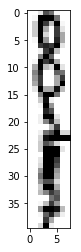

In [7]:
m = 5
sample = np.random.choice(X.shape[0], m)

plt.imshow(X[sample, 1:].reshape(-1, 8), cmap='Greys')
print(y[sample].flatten())

In [8]:
def one_v_all(X, y, n_classes, reg=.1):
    n_features = X.shape[1]
    
    theta0 = np.zeros((n_features, 1))
    thetas = np.zeros((n_classes, n_features))
    
    for cls in np.arange(n_classes):
        res = minimize(cost, theta0, args=(X, y==cls, reg), jac=cost_gradient, options={'maxiter':50})
        thetas[cls] = res.x
    return thetas

In [9]:
with np.errstate(divide='ignore'):
    theta = one_v_all(X, y, 10)

In [10]:
def predict_one_v_all(thetas, X):
    Ps = expit(X.dot(thetas.T))
    
    return np.argmax(Ps, axis=1)

In [11]:
pred = predict_one_v_all(theta, X)

print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 99.1652754590985 %


prediction: [2]
truth: [2]


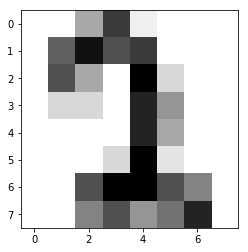

In [12]:
i = np.random.choice(X.shape[0])

plt.imshow(X[i, 1:].reshape(-1, 8), cmap='Greys')
print("prediction: {}".format(predict_one_v_all(theta, X[i:i+1])))
print("truth: {}".format(y[i]))

These are very controlled training samples though.  What do we do with less controlled, more realistic inputs?

# Neural Networks

In biology, a neuron serves to take a bunch of inputs, do some "computation", and send an output signal.

## Logistic Unit

In [13]:
import daft

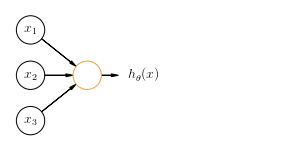

In [14]:
neuron_style = {"ec": "#f4a041"}
output_style = {"lw": 0}
label_style = {"lw": 0}

with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 14, 'text.usetex': True}):
    pgm = daft.PGM([4.7, 2.35], origin=[-1.35, 2.])

    xpos = -1
    pgm.add_node(daft.Node("x1", r"$x_1$", xpos, 4))
    pgm.add_node(daft.Node("x2", r"$x_2$", xpos, 3.2))
    pgm.add_node(daft.Node("x3", r"$x_3$", xpos, 2.4))

    xpos += 1
    pgm.add_node(daft.Node("neuron", "", 0, 3.2, plot_params=neuron_style))
    
    xpos += 1
    pgm.add_node(daft.Node("h", r"$h_\theta(x)$", 1, 3.2, aspect=1.8, plot_params=output_style))

    pgm.add_edge("x1", "neuron")
    pgm.add_edge("x2", "neuron")
    pgm.add_edge("x3", "neuron")
    pgm.add_edge("neuron", "h")

    pgm.render()

Some new terminology: the sigmoid function is an *activation function*, and parameters $\{\theta_1, \theta_2, \ldots\}$ can be called *weights*.

## Neural Network

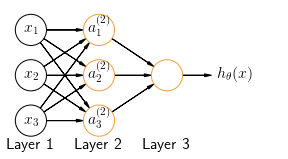

In [15]:
with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 16, 'text.usetex': True}):
    pgm = daft.PGM([4.7, 2.35], node_unit=1.1, origin=[-1.35, 2.])

    xpos = -1
    pgm.add_node(daft.Node("x1", r"$x_1$", xpos, 4))
    pgm.add_node(daft.Node("x2", r"$x_2$", xpos, 3.2))
    pgm.add_node(daft.Node("x3", r"$x_3$", xpos, 2.4))
    pgm.add_node(daft.Node("layer1", "Layer 1", xpos, 2, plot_params=label_style))

    xpos += 1.2
    pgm.add_node(daft.Node("neuron1", r"$a_1^{(2)}$", xpos, 4, plot_params=neuron_style))
    pgm.add_node(daft.Node("neuron2", r"$a_2^{(2)}$", xpos, 3.2, plot_params=neuron_style))
    pgm.add_node(daft.Node("neuron3", r"$a_3^{(2)}$", xpos, 2.4, plot_params=neuron_style))
    pgm.add_node(daft.Node("layer2", "Layer 2", xpos, 2, plot_params=label_style))

    xpos += 1.2
    pgm.add_node(daft.Node("out_neuron", "", xpos, 3.2, plot_params=neuron_style))
    pgm.add_node(daft.Node("layer3", "Layer 3", xpos, 2, plot_params=label_style))

    xpos += 1.2
    pgm.add_node(daft.Node("h", r"$h_\theta(x)$", xpos, 3.2, aspect=1.5, plot_params=output_style))

    for neuron in ["neuron1", "neuron2", "neuron3"]:
        for inp in ["x1", "x2", "x3"]:
            pgm.add_edge(inp, neuron)
        pgm.add_edge(neuron, "out_neuron")
    
    pgm.add_edge("out_neuron", "h")

    pgm.render()

Implicitly, each layer has a *bias unit* (e.g., $x_0$ for the first layer) to handle offsets.

Layer 1 is also referred to as the *input layer*, Layer 2 a *hidden layer*, and Layer 3 the *output layer*.

The $a_i^{(j)}$s represent the *activation* of unit $i$ in layer $j$, and we will pack all of the weights (i.e., parameters) into matrices $\Theta^{(j)}$ controlling the mapping from layer $j$ to layer $j+1$.

$$
a_1^{(2)} = g(\Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3) \\
a_2^{(2)} = g(\Theta_{20}^{(1)}x_0 + \Theta_{21}^{(1)}x_1 + \Theta_{22}^{(1)}x_2 + \Theta_{23}^{(1)}x_3) \\
a_3^{(2)} = g(\Theta_{30}^{(1)}x_0 + \Theta_{31}^{(1)}x_1 + \Theta_{32}^{(1)}x_2 + \Theta_{33}^{(1)}x_3) \\
h_\Theta(x) = a_1^{(3)} = g(\Theta_{10}^{(2)}a_0^{(2)} + \Theta_{11}^{(2)}a_1^{(2)} + \Theta_{12}^{(2)}a_2^{(2)} + \Theta_{13}^{(2)}a_3^{(2)}) \\
$$

So $\Theta^{(1)}$, which maps from our 3 input units to 3 hidden units, has shape `3,4`.  To save (virtual) ink we'll make use of the following notation
$$
z_1^{(2)} = \Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3
$$

so that

$$
a_1^{(2)} = g(z_1^{(2)}) = g(\Theta_{10}^{(1)}x_0 + \Theta_{11}^{(1)}x_1 + \Theta_{12}^{(1)}x_2 + \Theta_{13}^{(1)}x_3)
$$

### Vectorized

We'll have our usual feature vector
$$
x =
\begin{bmatrix}
    x_0 \\
    x_1 \\
    x_2 \\
    x_3
\end{bmatrix}
$$

and we'll define $z^{(2)}$ to be a vector of $z$'s
$$
z^{(2)} =
\begin{bmatrix}
    z_1^{(2)} \\
    z_2^{(2)} \\
    z_3^{(2)}
\end{bmatrix}
$$

So $z^{(2)}$ is a 3-D vector.

We can now write
$$
z^{(2)} = \Theta^{(1)}x \\
a^{(2)} = g(z^{(2)})
$$

So far we've called the inputs $\{x_1, x_2, x_3\}$, but to homogonize our notation, we can also refer to them as the activations of the first layer, $\{a_1^{(1)}, a_2^{(1)}, a_3^{(1)}\}$, so
$$
z^{(2)} = \Theta^{(1)}a^{(1)} \\
a^{(2)} = g(z^{(2)})
$$

We still need the hidden layer's bias unit, so we need to add $a_0^{(2)} = 1$ to our final feature vector, making it 4-D.  So your final prediction:
$$
z^{(3)} = \Theta^{(2)}a^{(2)} \\
h_\Theta(x) = a^{(3)} = g(z^{(3)})
$$

The flow if this computation is ofter called *forward propagation*.  So in the end we're still doing logistic regression at the end, except that instead of using the input features $\{x_1, x_2, x_3\}$, we're using the activation features $\{a_1^{(2)}, a_2^{(2)}, a_3^{(2)}\}$.

## Example XNOR

| A | B | A XOR B |
|:-:|:-:|:-:|
| 0 | 0 | 0 |
| 0 | 1 | 1 |
| 1 | 0 | 1 |
| 1 | 1 | 0 |

`XNOR` is just the logical negation of `XOR`, $A \mathrm{~XNOR~} B = \mathrm{~NOT~}(A \mathrm{~XOR~} B)$

| A | B | A XNOR B |
|:-:|:-:|:-:|
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

Let's teach this to a neural network.

## Simpler example: AND,  OR

Consider $x_1, x_2 \in \{0, 1\}$, and $y = x_1 \mathrm{~AND~}x_2$.

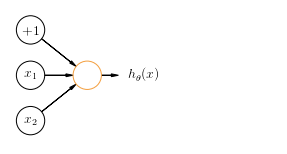

In [16]:
with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 14, 'text.usetex': True}):
    pgm = daft.PGM([4.7, 2.35], origin=[-1.35, 2.])

    xpos = -1
    pgm.add_node(daft.Node("bias", r"$+1$", xpos, 4))
    pgm.add_node(daft.Node("x1", r"$x_1$", xpos, 3.2))
    pgm.add_node(daft.Node("x2", r"$x_2$", xpos, 2.4))

    xpos += 1
    pgm.add_node(daft.Node("neuron", "", 0, 3.2, plot_params=neuron_style))
    
    xpos += 1
    pgm.add_node(daft.Node("h", r"$h_\theta(x)$", 1, 3.2, aspect=1.8, plot_params=output_style))

    pgm.add_edge("bias", "neuron")
    pgm.add_edge("x1", "neuron")
    pgm.add_edge("x2", "neuron")
    pgm.add_edge("neuron", "h")

    pgm.render()

Let's assign weights $\Theta_0=-30, \Theta_1=20, \Theta_2=20$.  Using the above network,

$$
h_\Theta(x) = g(-30 + 20x_1 + 20x_2)
$$

| $x_1$ | $x_2$ | $h_\Theta(x)$ |
|---|---|--------|
| 0 | 0 | $g(-30) \approx 0$ |
| 0 | 1 | $g(-10) \approx 0$ |
| 1 | 0 | $g(-10) \approx 0$ |
| 1 | 1 | $g(10) \approx 1$ |

So this behaves like $x_1 \mathrm{~AND~} x_2$.

What about $\Theta_0=-10, \Theta_1=20, \Theta_2=20$.

$$
h_\Theta(x) = g(-10 + 20x_1 + 20x_2)
$$

| $x_1$ | $x_2$ | $h_\Theta(x)$ |
|---|---|--------|
| 0 | 0 | $g(-10) \approx 0$ |
| 0 | 1 | $g(10) \approx 1$ |
| 1 | 0 | $g(10) \approx 1$ |
| 1 | 1 | $g(30) \approx 1$ |

So this behaves like $x_1 \mathrm{~OR~} x_2$.


## Simplest example: negation

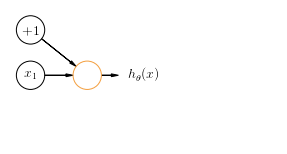

In [17]:
with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 14, 'text.usetex': True}):
    pgm = daft.PGM([4.7, 2.35], origin=[-1.35, 2.])

    xpos = -1
    pgm.add_node(daft.Node("bias", r"$+1$", xpos, 4))
    pgm.add_node(daft.Node("x1", r"$x_1$", xpos, 3.2))

    xpos += 1
    pgm.add_node(daft.Node("neuron", "", 0, 3.2, plot_params=neuron_style))
    
    xpos += 1
    pgm.add_node(daft.Node("h", r"$h_\theta(x)$", 1, 3.2, aspect=1.8, plot_params=output_style))

    pgm.add_edge("bias", "neuron")
    pgm.add_edge("x1", "neuron")
    pgm.add_edge("neuron", "h")

    pgm.render()

Let's use this network with weights $\Theta_0=10, \Theta_1=-20$.

$$
h_\Theta(x) = g(10 - 20x_1)
$$

| $x_1$ | $h_\Theta(x)$ |
|---|---|
| 0 | $g(10) \approx 1$ |
| 1 | $g(-10) \approx 0$ |

So this behaves like $\mathrm{NOT~}x_1$.

We can extend this idea to make $(\mathrm{~NOT~}x_1)\mathrm{~AND~}(\mathrm{~NOT~}x_2)$ when 
$\Theta_0=10, \Theta_1=-20, \Theta_2=-20$.  This will be useful later.

| $x_1$ | $x_2$ | $h_\Theta(x)$ |
|---|---|----|
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 0 |

## Bring it together to build XNOR

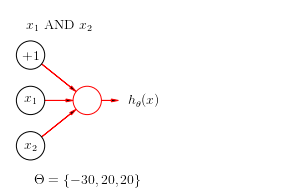

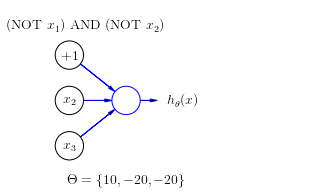

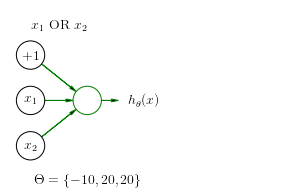

In [18]:
and_style = {"ec": "r"}
nandn_style = {"ec": "b"}
or_style = {"ec": "g"}

output_style = {"lw": 0}
label_style = {"lw": 0}

with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 14, 'text.usetex': True}):
    pgm = daft.PGM([4.7, 3], origin=[-1.35, 1.8])

    xpos = -1
    pgm.add_node(daft.Node("bias", r"$+1$", xpos, 4))
    pgm.add_node(daft.Node("x1", r"$x_1$", xpos, 3.2))
    pgm.add_node(daft.Node("x2", r"$x_2$", xpos, 2.4))
    pgm.add_node(daft.Node("and", r"$x_1 ~\mathrm{AND}~ x_2$", xpos+.5, 4.5, plot_params=label_style))
    pgm.add_node(daft.Node("theta", r"$\Theta=\{-30, 20, 20\}$", xpos+1, 1.8, plot_params=label_style))

    xpos += 1
    pgm.add_node(daft.Node("neuron", "", 0, 3.2, plot_params=and_style))
    
    xpos += 1
    pgm.add_node(daft.Node("h", r"$h_\theta(x)$", 1, 3.2, aspect=1.8, plot_params=output_style))

    pgm.add_edge("bias", "neuron", **and_style)
    pgm.add_edge("x1", "neuron", **and_style)
    pgm.add_edge("x2", "neuron", **and_style)
    pgm.add_edge("neuron", "h", **and_style)

    pgm.render()
    
with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 14, 'text.usetex': True}):
    pgm = daft.PGM([4.7, 3], origin=[-1.35, 1.8])

    xpos = -1
    pgm.add_node(daft.Node("bias", r"$+1$", xpos, 4))
    pgm.add_node(daft.Node("x1", r"$x_2$", xpos, 3.2))
    pgm.add_node(daft.Node("x2", r"$x_3$", xpos, 2.4))
    pgm.add_node(daft.Node("and", r"$(\mathrm{NOT}~x_1) ~\mathrm{AND}~ (\mathrm{NOT}~x_2)$", xpos+.3, 4.5, plot_params=label_style))
    pgm.add_node(daft.Node("theta", r"$\Theta=\{10, -20, -20\}$", xpos+1, 1.8, plot_params=label_style))

    xpos += 1
    pgm.add_node(daft.Node("neuron", "", 0, 3.2, plot_params=nandn_style))
    
    xpos += 1
    pgm.add_node(daft.Node("h", r"$h_\theta(x)$", 1, 3.2, aspect=1.8, plot_params=output_style))

    pgm.add_edge("bias", "neuron", **nandn_style)
    pgm.add_edge("x1", "neuron", **nandn_style)
    pgm.add_edge("x2", "neuron", **nandn_style)
    pgm.add_edge("neuron", "h", **nandn_style)

    pgm.render()
    
with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 14, 'text.usetex': True}):
    pgm = daft.PGM([4.7, 3], origin=[-1.35, 1.8])

    xpos = -1
    pgm.add_node(daft.Node("bias", r"$+1$", xpos, 4))
    pgm.add_node(daft.Node("x1", r"$x_1$", xpos, 3.2))
    pgm.add_node(daft.Node("x2", r"$x_2$", xpos, 2.4))
    pgm.add_node(daft.Node("and", r"$x_1 ~\mathrm{OR}~ x_2$", xpos+.5, 4.5, plot_params=label_style))
    pgm.add_node(daft.Node("theta", r"$\Theta=\{-10, 20, 20\}$", xpos+1, 1.8, plot_params=label_style))

    xpos += 1
    pgm.add_node(daft.Node("neuron", "", 0, 3.2, plot_params=or_style))
    
    xpos += 1
    pgm.add_node(daft.Node("h", r"$h_\theta(x)$", 1, 3.2, aspect=1.8, plot_params=output_style))

    pgm.add_edge("bias", "neuron", **or_style)
    pgm.add_edge("x1", "neuron", **or_style)
    pgm.add_edge("x2", "neuron", **or_style)
    pgm.add_edge("neuron", "h", **or_style)

    pgm.render()

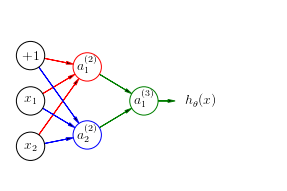

In [19]:
with mpl.rc_context(rc={'font.family': 'serif', 'font.size': 14, 'text.usetex': True}):
    pgm = daft.PGM([4.7, 3], origin=[-1.35, 1.8])

    xpos = -1
    pgm.add_node(daft.Node("bias", r"$+1$", xpos, 4))
    pgm.add_node(daft.Node("x1", r"$x_1$", xpos, 3.2))
    pgm.add_node(daft.Node("x2", r"$x_2$", xpos, 2.4))

    xpos += 1
    pgm.add_node(daft.Node("a21", r"$a_1^{(2)}$", xpos, 3.8, plot_params=and_style))
    
    pgm.add_edge("bias", "a21", **and_style)
    pgm.add_edge("x1", "a21", **and_style)
    pgm.add_edge("x2", "a21", **and_style)

    pgm.add_node(daft.Node("a22", r"$a_2^{(2)}$", xpos, 2.6, plot_params=nandn_style))
    
    pgm.add_edge("bias", "a22", **nandn_style)
    pgm.add_edge("x1", "a22", **nandn_style)
    pgm.add_edge("x2", "a22", **nandn_style)

    xpos += 1
    pgm.add_node(daft.Node("a31", r"$a_1^{(3)}$", xpos, 3.2, plot_params=or_style))
    
    pgm.add_edge("a21", "a31", **or_style)
    pgm.add_edge("a22", "a31", **or_style)
    
    xpos += 1
    pgm.add_node(daft.Node("h", r"$h_\theta(x)$", xpos, 3.2, aspect=1.8, plot_params=output_style))

    pgm.add_edge("a31", "h", **or_style)

    pgm.render()

| $x_1$ | $x_2$ | $a_1^{(2)}$ | $a_2^{(2)}$ | $h_\Theta(x)$ |
|---|---|---|---|---|
| 0 | 0 | 0 | 1 | 1 |
| 0 | 1 | 0 | 0 | 0 |
| 1 | 0 | 0 | 0 | 0 |
| 1 | 1 | 1 | 0 | 1 |

# Cost function

First let's define a few parameters for our network: $L$ is the number of layers in the network, $s_l$ is the number of units (not counting the bias unit) in layer $l$, and $K$ is the number of outputs $h_\Theta(x)_k$ (we can have more than one).

Recall our cost function for regularized logistic regression

$$
J(\theta) = -\frac{1}{m}\left[\sum_{i=1}^m y^{(i)}\log h_\theta(x^{(i)}) + (1 - y^{(i)})\log (1 - h_\theta(x^{(i)})\right] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2
$$

For neural networks we need to account for multiple output nodes and multiple parameter matrices

$$
J(\theta) = -\frac{1}{m}\left[\sum_{i=1}^m \sum_{k=1}^K y^{(i)}_k\log h_\theta(x^{(i)})_k + (1 - y^{(i)}_k)\log (1 - h_\theta(x^{(i)})_k\right] + \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l} \sum_{j=1}^{s_{l+1}} (\Theta_{j,i}^{(l)})^2
$$